# Inference Example

This notebook illustrates how the inference algorithm can be used to estimate outbreak origins.

We'll use some sample data generated from a dEPR model to illustrate how the method finds locations.

In [2]:
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['figure.facecolor'] = 'w'
import matplotlib.pyplot as plt

## Load input trajectories

First we load trajectories of 1000 individuals, generated from a dEPR model for the area of Berlin.


The trajectory data consist of the columns:
 - ind: An identifier of the individual
 - t: The timestamp of observations
 - lon/lat: The location of the observations

In [3]:
traj = pd.read_csv('../data/sample_trajectories_N1000.csv')
traj.head()

,ind,t,lon,lat
0,0,0.0000,13.4774,52.5021
1,0,6.4538,13.4923,52.4909
2,0,7.0046,13.4892,52.4913
3,0,8.9135,13.4511,52.5059
4,0,10.7044,13.4724,52.4925


Here is an illustration of all the observations that are included in the dataset. Each dot is a single geo-located, timestamped observation of an individual.

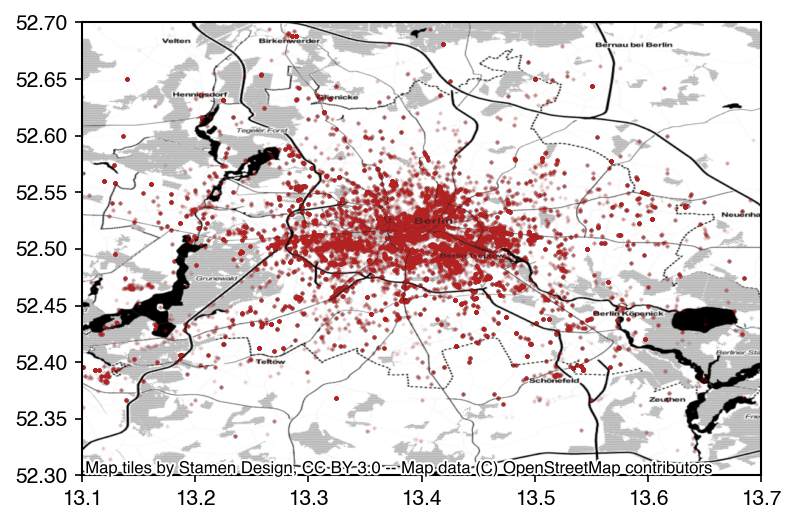

In [4]:
import contextily as cx
fig, ax = plt.subplots()
ax.scatter(traj['lon'], traj['lat'], s=1, color='firebrick', alpha=0.01)
ax.set_xlim([13.1,13.7])
ax.set_ylim([52.3,52.7])
cx.add_basemap(ax, crs="EPSG:4326", source=cx.providers.Stamen.Toner)
plt.show()

## Preparing a sample of individual trajectories

The inference method is intended for a scenario where we are given a sample of a few individuals, for which we assume that some or all have visited at an outbreak origin at the same time.

To illustrate the method, we thus first choose a small sample of 4 trajectories - these are our "infected" patients.

Note that we choose random individuals here, so we don't really expect them to have been co-located at one point.

In [5]:
sample_individuals = [0,1,3,4]

sample_trajectories = traj.loc[traj['ind'].isin(sample_individuals)]

 As one can see, the individuals generally move in distinct "neighborhoods", centered around their home location, which is an example of trajectories generated from an dEPR model.


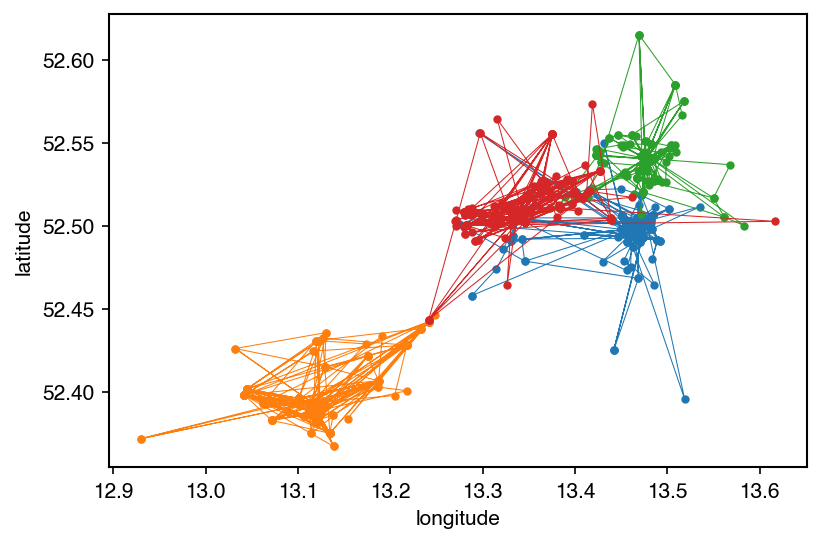

In [6]:
from outbreak.util import plot_trajectories
plot_trajectories(sample_trajectories)

We limit the sample to a short section from the full tractories, representing the simulated movements over 100 hours.

We can actually see that a meeting between the blue and red individual occurs, where blue meets the red individual at its home location.


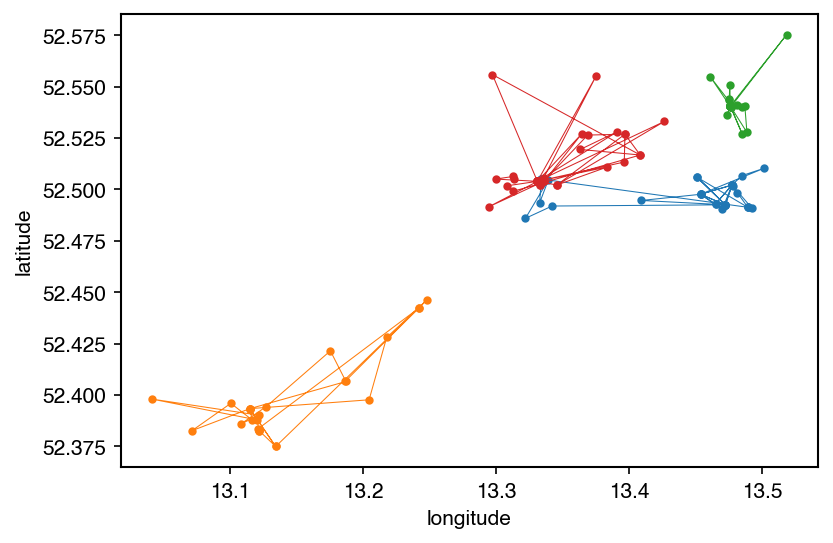

In [7]:
sample_trajectories = sample_trajectories.loc[sample_trajectories['t'] < 100]
plot_trajectories(sample_trajectories)

## Inference Method

We now initialize the inference method, using its standard parameters, and apply it to the sample trajectories of the 4 individuals above.

The inference method looks for co-locations among the individuals. For each time step, it places gaussian distributions at the location of each individual, and then looks for maxima of the aggregate distribution. If individuals are close together, they create a maxima. The highest maxima over all time steps is the estimated outbreak origin.

In the example here, the method identifies the co-location of the blue and red individuals as the most likely outbreak origin.

The score of the top location is slightly below 0.5. That would be the score if two individuals (half of the sample) were directly on top of each other. So the score indicates that half of the individuals in the sample were co-located. The other scores are close to 0.25, meaning that just a single individual was present

In [8]:
from outbreak import Inference

inference = Inference()

origins = inference.find_outbreak_origins(sample_trajectories)
origins.head()

,loc_id,lat,lon,score,time
0,0,52.50445,13.33255,0.463122,1970-01-04 15:30:00
1,1,52.50345,13.33345,0.458717,1970-01-04 14:37:30
2,2,52.48590,13.32210,0.250001,1970-01-04 11:00:00
3,3,52.50390,13.33110,0.250001,1970-01-04 11:00:00
9,9,52.49290,13.46500,0.250000,1970-01-02 16:58:45


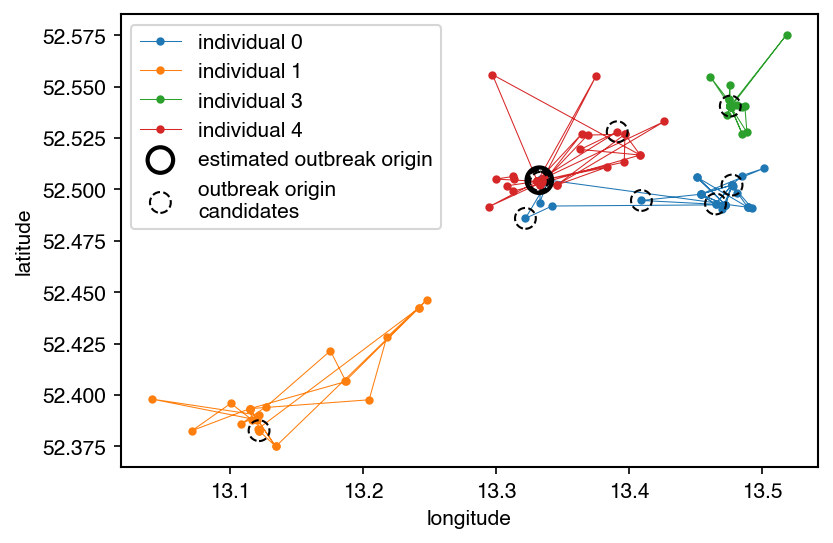

In [9]:
from outbreak.util import plot_result
plot_result(sample_trajectories, origins, n_origins=10)
plt.show()

## Effect of the gaussian variance on the inference

The variance *sigma* of the gaussian distribution used to represent the position of each individual is the main parameter of the inference algorithm. It is given in units if km to the algorithm.

The variance should be adjusted according to the spatial scale on which the algorithm is used.

The below plots show the effect of different values *sigma*.

For small values, the distributions around each individuals fall of quickly, and maxima are only created when individuals are close together. In the example, the meeting of the blue and red individuals is deemed the most likely outbreak origin.

For higher values, the distributions are wider, and the distributions of more distant individuals are more likely to overlap. In the example, the general area between the blue, red and green individuals becomes the likely outbreak location.

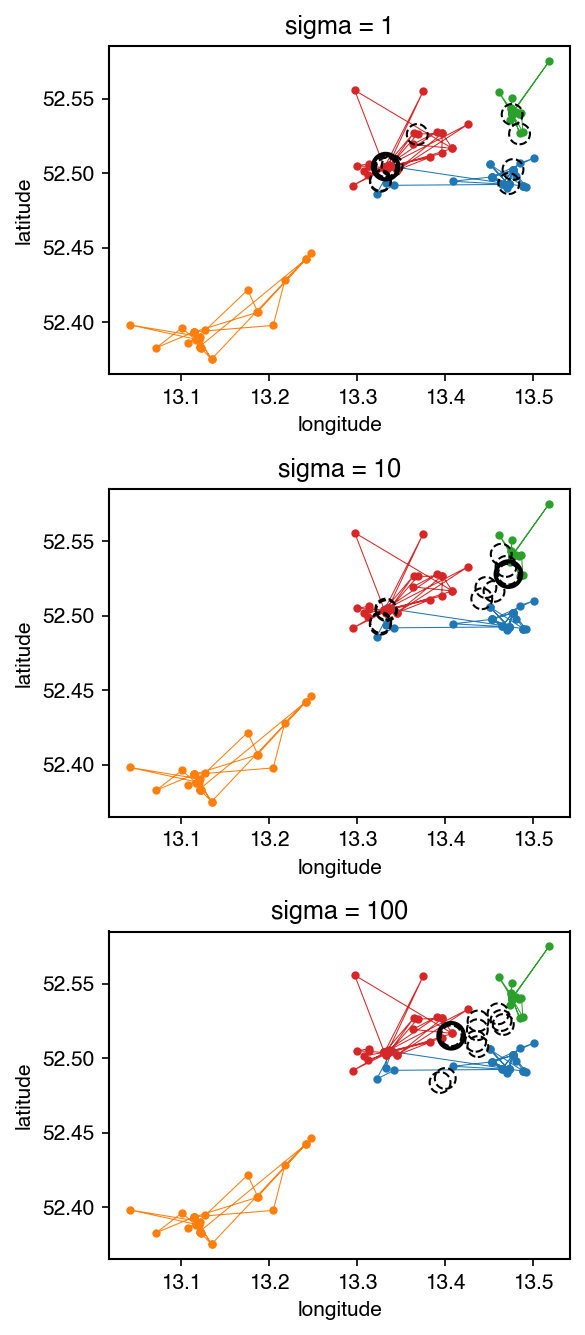

In [10]:
sigmas = [1,10,100]
fig, axes = plt.subplots(3,1, figsize=(4,9))

for sigma, ax in zip(sigmas, axes):

    inference = Inference(GAUSS_SIGMA=sigma, MAX_NEIGHBORHOOD_SIZE_KM=1)
    origins = inference.find_outbreak_origins(sample_trajectories)
    plot_result(sample_trajectories, origins, n_origins=10, ax=ax, legend=False)
    ax.set_title('sigma = {}'.format(sigma))
fig.patch.set_facecolor('w')
plt.tight_layout()
plt.show()
